# Emcee hammer: extensive testing on toy problems

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import pints.plot

from pints.functionaltests.emcee_hammer import (
    test_emcee_hammer_on_banana,
    test_emcee_hammer_on_two_dim_gaussian,
    test_emcee_hammer_on_correlated_gaussian,
    test_emcee_hammer_on_annulus)

In [2]:
def run_replicates(iterations, n_replicates, test):
    df = pd.DataFrame(columns=['iterations', 'replicate', 'kld', 'ess'],
                      index=np.arange(len(iterations) * n_replicates))
    k = 0
    for it in iterations:
        for rep in range(n_replicates):
            result = test(it)
            df.iloc[k] = {'iterations': it, 'replicate': rep,
                          'kld': result['kld'], 'ess': result['mean-ess']}
            k += 1
    df['iterations'] = pd.to_numeric(df['iterations'])
    df['kld'] = pd.to_numeric(df['kld'])
    df['ess'] = pd.to_numeric(df['ess'])
    return df

def ecdf_norm_plotter(draws, normal_sd, xrange=np.linspace(-5, 5, 100)):
    from scipy.stats import norm
    from statsmodels.distributions.empirical_distribution import ECDF
    ecdf_fun = ECDF(draws)
    ecdf = [ecdf_fun(y) for y in xrange]
    cdf = [norm.cdf(y, 0, normal_sd) for y in xrange]
    
    x1 = np.linspace(0, 1, 100)
    y = [y for y in x1]
    plt.scatter(ecdf, cdf)
    plt.plot(x1, y, 'k-')
    plt.xlabel('Estimated cdf')
    plt.ylabel('True cdf')
    plt.show()

# Two dimensional Gaussian

/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


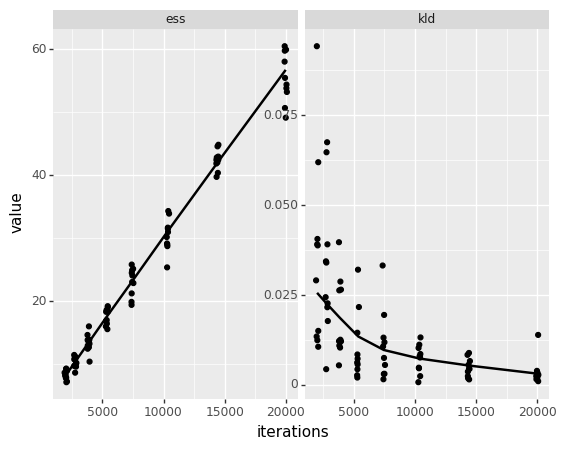

<ggplot: (344639213)>

In [3]:
low = np.log10(2000)
high = np.log10(20000)
test = run_replicates(10**np.linspace(low, high, 8), 10, test_emcee_hammer_on_two_dim_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/emcee_hammer_2d_gaussian.csv")
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The ESS and KLD both trend in the correct directions.

Show example run results.

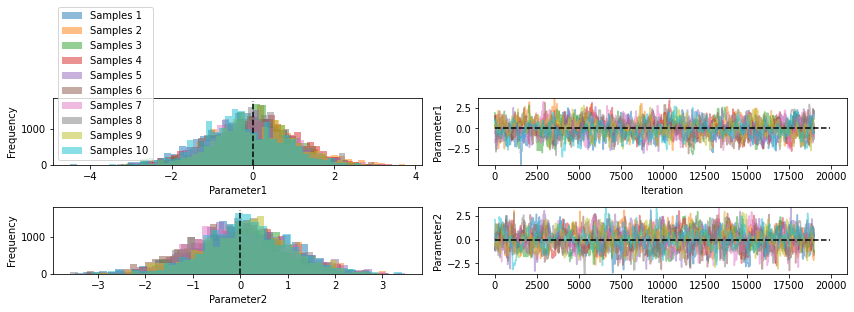

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  -0.03   0.99    -2.00   -0.68  -0.03  0.62   1.93     1.02    642.29  158.22
param 2  0.04    1.00    -1.92   -0.62  0.04   0.70   2.01     1.02    642.06  158.16


In [17]:
n_chains = 10
n_iterations = 20000
n_warmup = 1000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.EmceeHammerMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

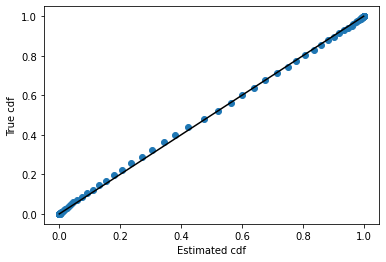

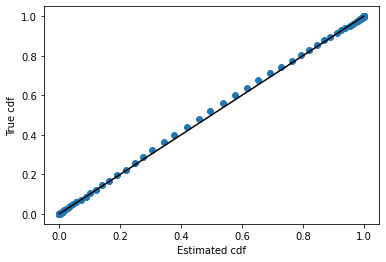

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


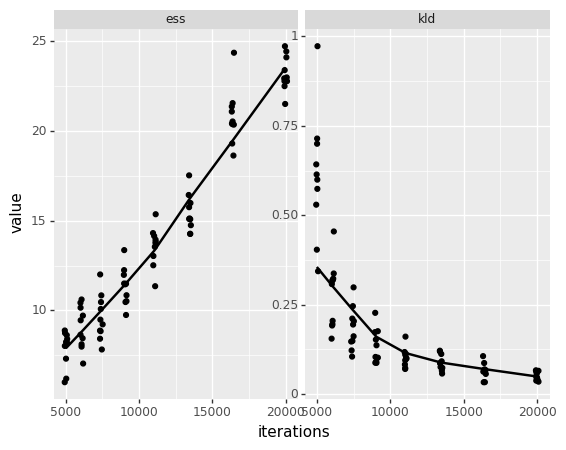

<ggplot: (349673869)>

In [6]:
low = np.log10(5000)
high = np.log10(20000)
test = run_replicates(10**np.linspace(low, high, 8), 10,
                      test_emcee_hammer_on_correlated_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/emcee_hammer_correlated_gaussian.csv")
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Example run of results.

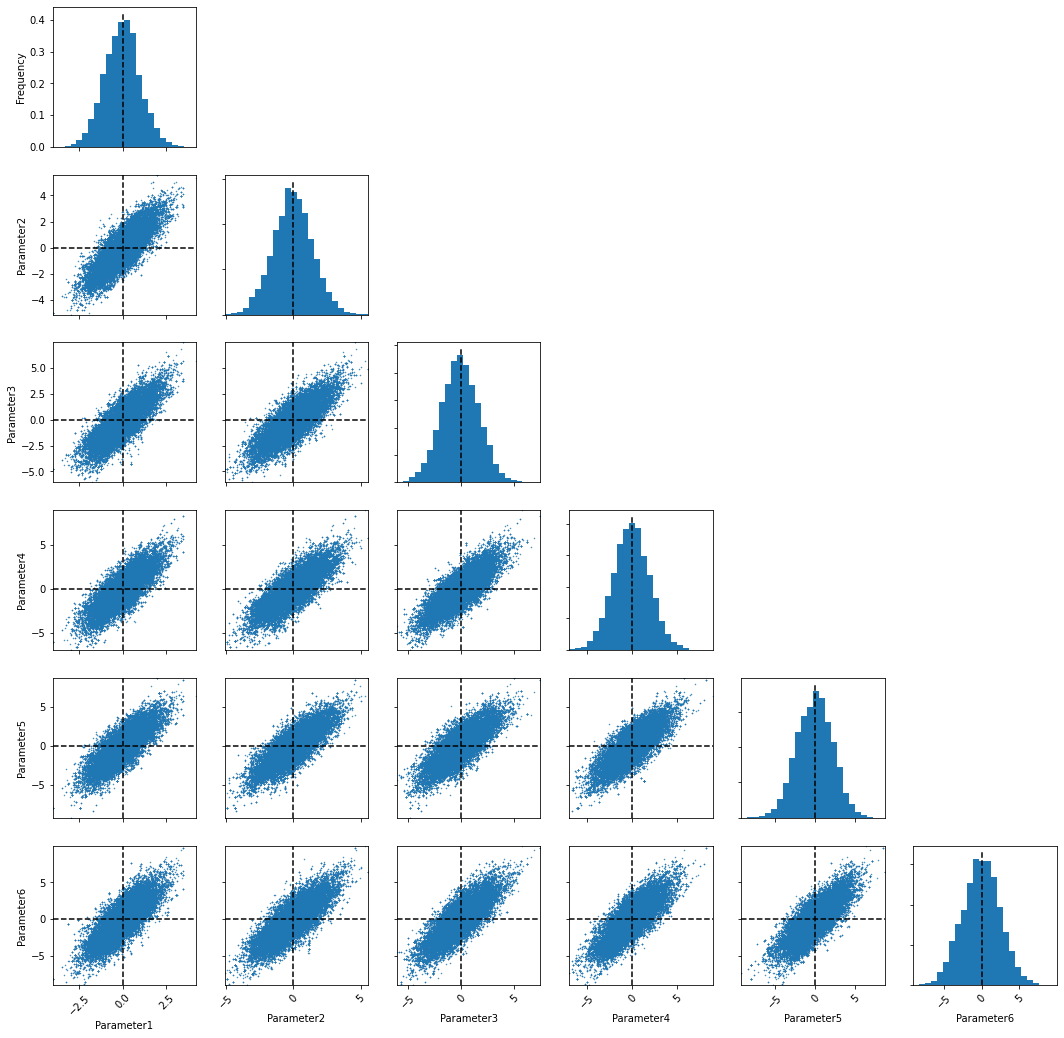

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  -0.02   1.01    -1.98   -0.70  -0.01  0.64   1.98     1.03    411.57  68.26
param 2  -0.03   1.46    -2.91   -1.00  -0.04  0.94   2.86     1.02    423.55  70.24
param 3  -0.11   1.74    -3.52   -1.29  -0.12  1.07   3.28     1.04    404.84  67.14
param 4  -0.06   1.99    -3.99   -1.40  -0.04  1.24   3.86     1.03    406.16  67.36
param 5  -0.07   2.22    -4.44   -1.63  -0.03  1.45   4.19     1.03    399.84  66.31
param 6  -0.01   2.51    -4.89   -1.68  0.02   1.66   4.88     1.03    377.42  62.59


In [18]:
n_chains = 10
n_iterations = 30000
n_warmup = 2000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.EmceeHammerMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

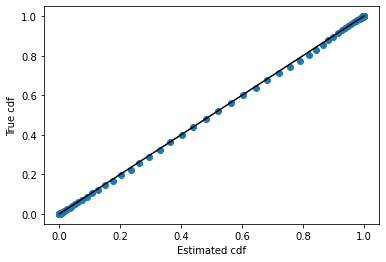

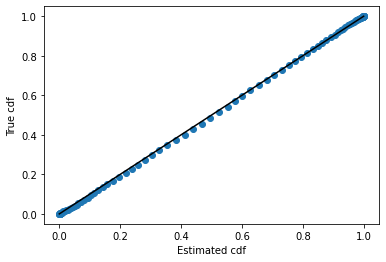

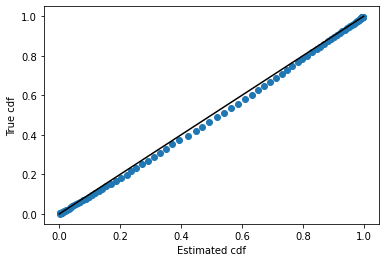

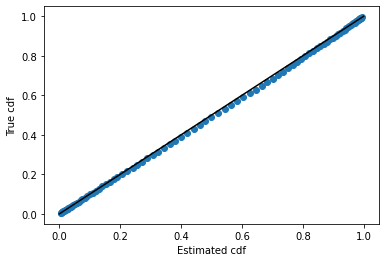

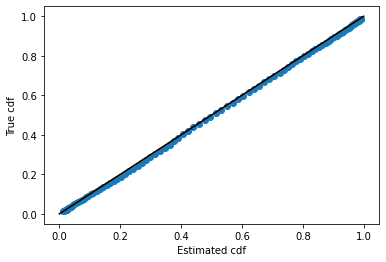

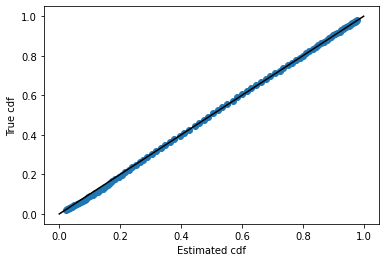

[None, None, None, None, None, None]

In [19]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


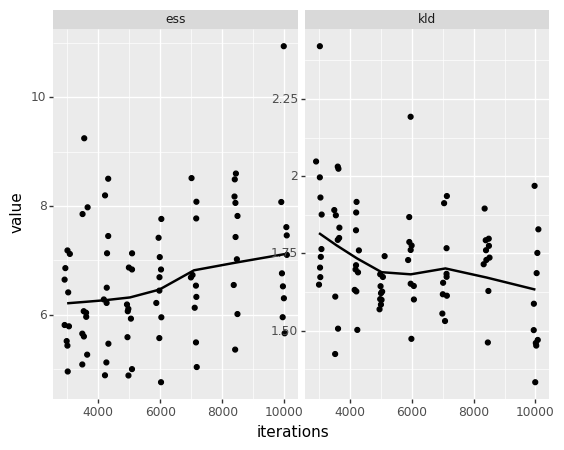

<ggplot: (349202985)>

In [9]:
low = np.log10(3000)
high = np.log10(10000)
test = run_replicates(10**np.linspace(low, high, 8), 10, test_emcee_hammer_on_banana)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/emcee_hammer_banana.csv")
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The banana is a hard problem. Because of this, both the ESS and KLD do not behave well. It's likely that this is due to the problem being too hard for this sampler, rather than there being an issue with the method itself.

Example run of results.

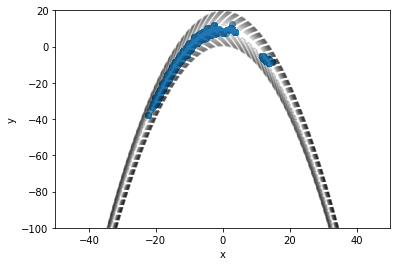

In [10]:
n_chains = 4
n_iterations = 4000
n_warmup = 1000

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.EmceeHammerMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Annulus

In [11]:
def run_replicates_annulus(iterations, n_replicates, test):
    df = pd.DataFrame(columns=['iterations', 'replicate', 'distance', 'ess'],
                      index=np.arange(len(iterations) * n_replicates))
    k = 0
    for it in iterations:
        for rep in range(n_replicates):
            result = test(it)
            df.iloc[k] = {'iterations': it, 'replicate': rep,
                          'distance': result['distance'], 'ess': result['mean-ess']}
            k += 1
    df['iterations'] = pd.to_numeric(df['iterations'])
    df['distance'] = pd.to_numeric(df['distance'])
    df['ess'] = pd.to_numeric(df['ess'])
    return df

/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


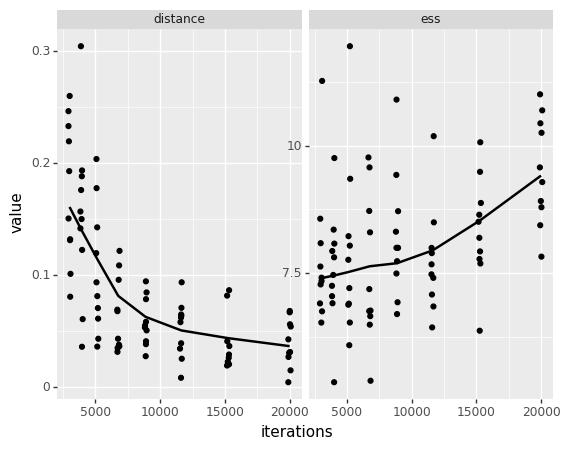

<ggplot: (349211677)>

In [12]:
low = np.log10(3000)
high = np.log10(20000)
test = run_replicates_annulus(10**np.linspace(low, high, 8), 10,
                              test_emcee_hammer_on_annulus)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/emcee_hammer_annulus.csv")
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Example run.

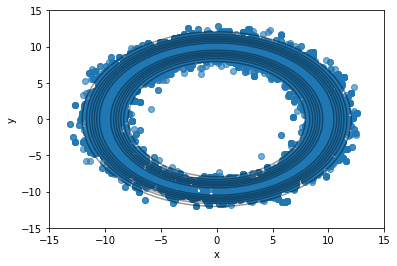

In [13]:
n_chains = 4
n_iterations = 20000
n_warmup = 2000

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.EmceeHammerMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

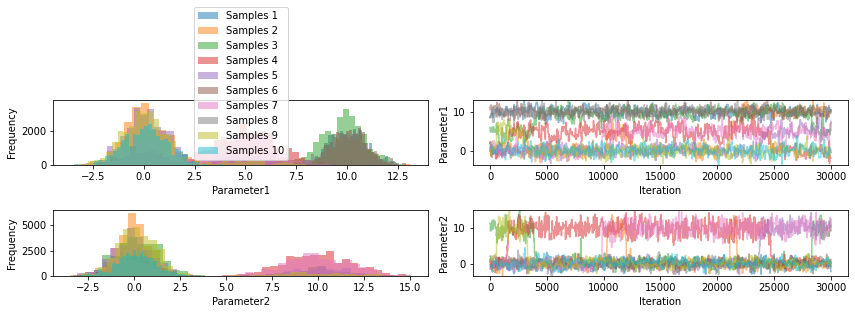

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  5.11    4.58    -1.52   0.39   5.20   9.74   11.49    2.34    855.42  82.48
param 2  2.03    4.16    -1.92   -0.46  0.36   1.60   12.03    1.49    453.97  43.77


In [25]:
n_chains = 10
n_iterations = 20000
n_warmup = 2000

covariances = [[[1, 0], [0, 1]],
               [[2, 0.8], [0.8, 3]],
               [[1, -0.5], [-0.5, 1]]]
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[0, 0], [5, 10], [10, 0]],
                                             covariances=covariances)
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.EmceeHammerMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()

pints.plot.trace(chains)

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

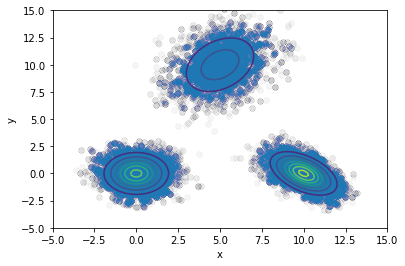

In [30]:
samples = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.005)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()